Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

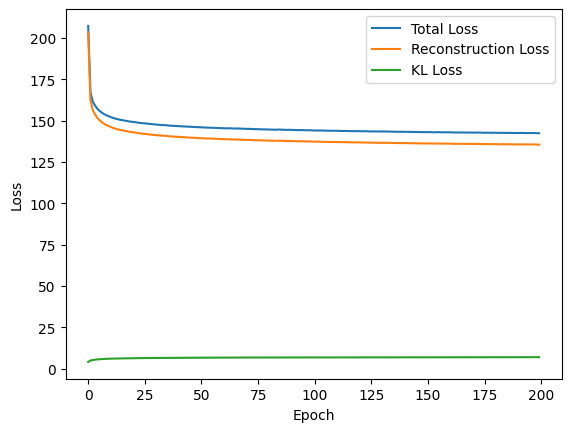

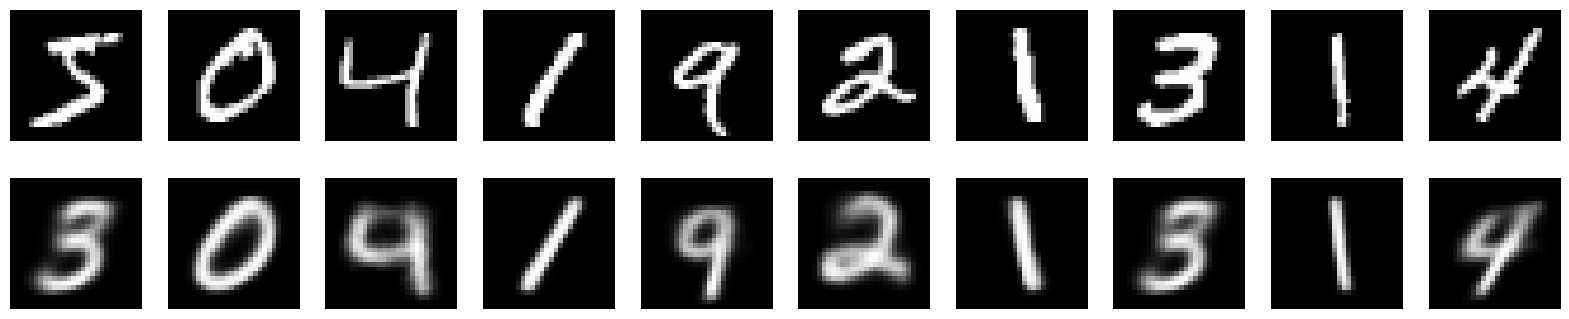

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import layers


import matplotlib.pyplot as plt


class SampleLayer(layers.Layer):
    """Sampling layer for vector encoding."""

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon


class VariationalAutoencoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


if __name__ == "__main__":
    latent_dim = 2

    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    mean = layers.Dense(latent_dim, name="mean")(x)
    log_var = layers.Dense(latent_dim, name="log_var")(x)
    z = SampleLayer()([mean, log_var])
    encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
    encoder.summary()

    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    mnist_digits = np.concatenate([x_train, x_test], axis=0)
    mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

    vae = VariationalAutoencoder(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit(mnist_digits, epochs=200, batch_size=128)

    plt.plot(vae.history.history['loss'], label='Total Loss')
    plt.plot(vae.history.history['reconstruction_loss'], label='Reconstruction Loss')
    plt.plot(vae.history.history['kl_loss'], label='KL Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.show()

    n_samples = 10
    plt.figure(figsize=(20, 4))

    for i in range(n_samples):
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(mnist_digits[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        _, _, z_sample = vae.encoder.predict(np.expand_dims(mnist_digits[i], axis=0))
        reconstructed_img = vae.decoder.predict(z_sample, verbose=0)
        plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(reconstructed_img[0].reshape(28, 28), cmap='gray')
        plt.axis('off')


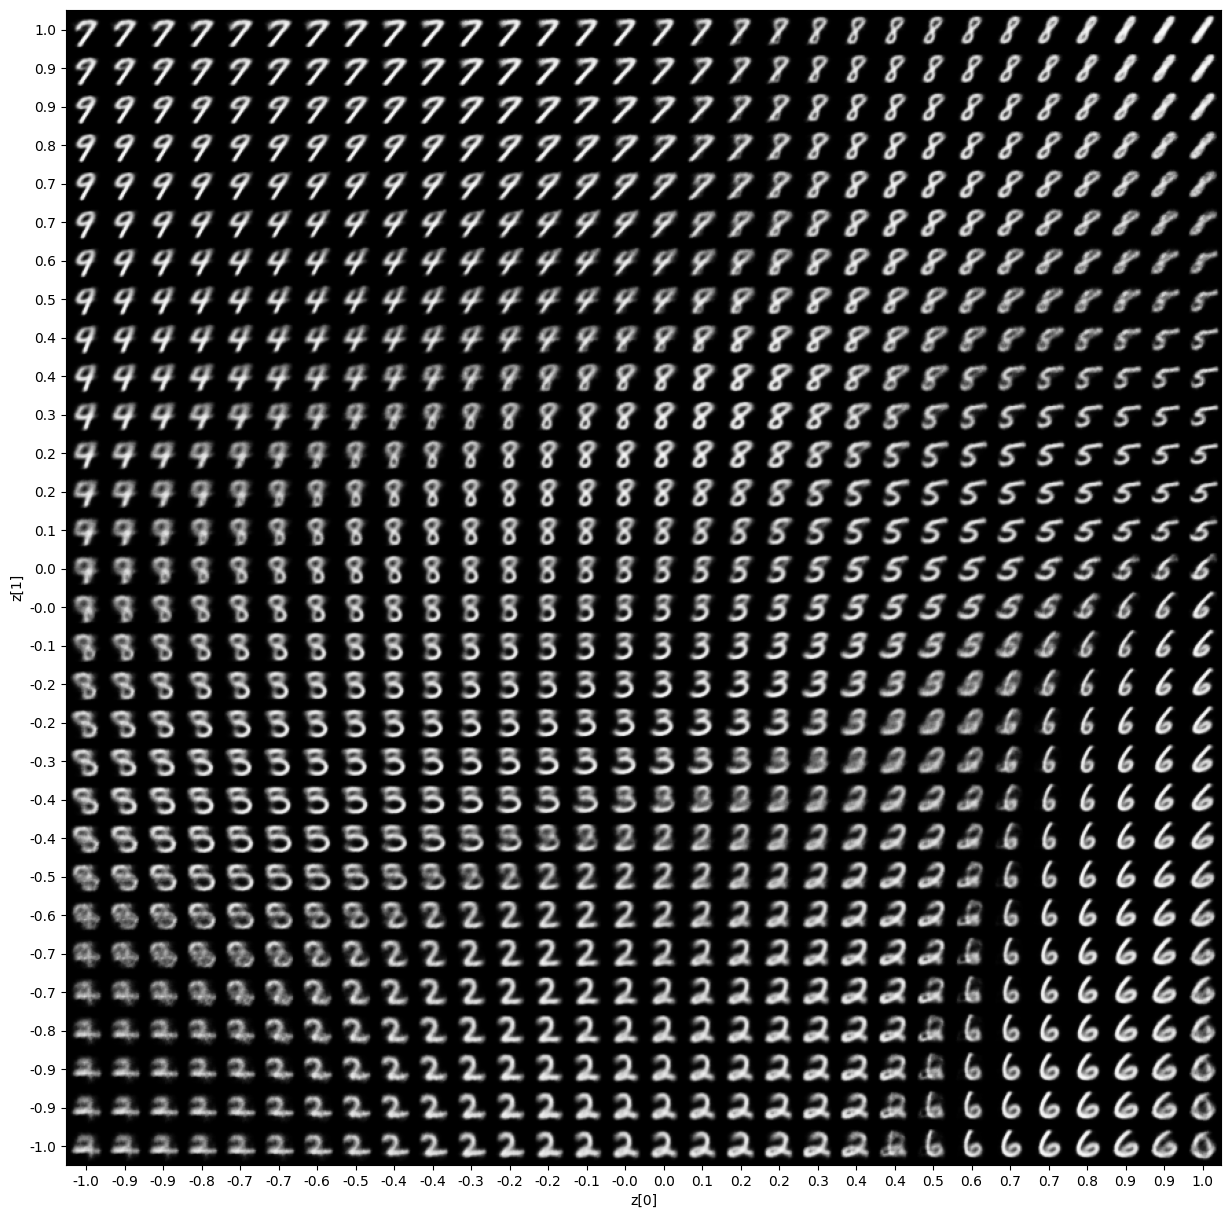

In [ ]:

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)




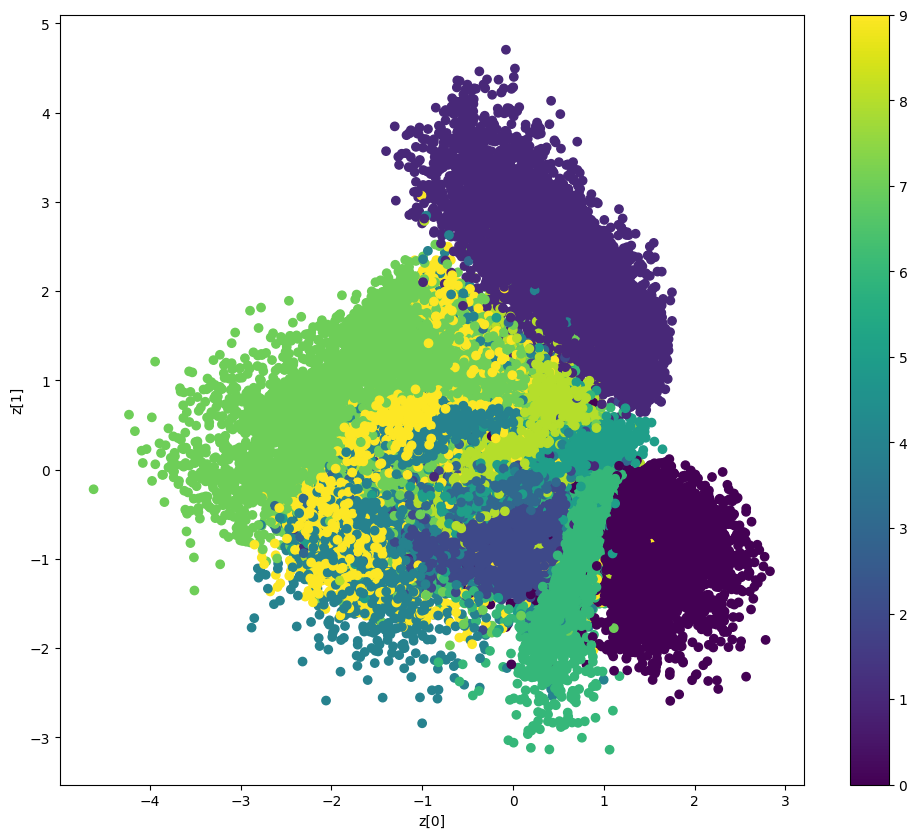

In [ ]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

class Sampling(layers.Layer):
    """Sampling layer for vector encoding."""
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.accuracy_tracker = keras.metrics.Mean(name="accuracy")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.accuracy_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),  # Ajustar los ejes para que coincidan con la forma de data
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

            # Calcular accuracy (similitud entre imágenes de entrada y reconstruidas)
            accuracy = tf.reduce_mean(tf.image.ssim(data, reconstruction, max_val=1.0))

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.accuracy_tracker.update_state(accuracy)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "accuracy": self.accuracy_tracker.result(),
        }

if __name__ == "__main__":
    latent_dim = 2

    # Encoder
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(8, 5, activation="relu", padding="same")(encoder_inputs)
    x = layers.Conv2D(16, 5, activation="relu", padding="same")(x)
    x = layers.Conv2D(32, 5, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 5, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 5, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    mean = layers.Dense(latent_dim, name="mean")(x)
    log_var = layers.Dense(latent_dim, name="log_var")(x)
    z = Sampling()([mean, log_var])
    encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
    encoder.summary()

    # Decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder_outputs = layers.Reshape((28, 28, 1))(decoder_outputs)  # Ajustar la forma de salida
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    # Cargar datos MNIST
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    mnist_digits = np.concatenate([x_train, x_test], axis=0)
    mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

    # VAE Model
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
    vae.fit(mnist_digits, epochs=50, batch_size=128)

    # Plotting
    plt.plot(vae.history.history['loss'], label='Total Loss')
    plt.plot(vae.history.history['reconstruction_loss'], label='Reconstruction Loss')
    plt.plot(vae.history.history['kl_loss'], label='KL Loss')
    plt.plot(vae.history.history['accuracy'], label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.show()

    # Visualización de ejemplos
    n_samples = 10
    plt.figure(figsize=(20, 4))

    for i in range(n_samples):
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(mnist_digits[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        _, _, z_sample = vae.encoder.predict(np.expand_dims(mnist_digits[i], axis=0))
        reconstructed_img = vae.decoder.predict(z_sample, verbose=0)
        plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(reconstructed_img[0].reshape(28, 28), cmap='gray')
        plt.axis('off')


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 28, 28, 8)            208       ['input_25[0][0]']            
                                                                                                  
 conv2d_58 (Conv2D)          (None, 28, 28, 16)           3216      ['conv2d_57[0][0]']           
                                                                                                  
 conv2d_59 (Conv2D)          (None, 28, 28, 32)           12832     ['conv2d_58[0][0]']           
                                                                                            